# Introduction

This file is used to generate most of the tables and plots in the CrowdPlay paper, and also serves as a set of examples of how to use the CrowdPlay dataset API.


## Start
We first load all prerequisites, and initialize the dataset engine. We then load all the episodes, users, etc. from the dataset. This takes a while; In practice, if you do not need the entire dataset, it can be faster to filter using an SQL query at this stage already - see the offline RL script for an example. On the other hand, if you load the entire dataset, you can then filter using native Python code (e.g. list comprehension), which can be convenient.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import math
import seaborn as sns
from datetime import datetime, timedelta
sns.set()

from crowdplay_datasets.dataset import get_trajectory_by_id, get_engine_and_session, EpisodeModel, UserModel, EnvironmentModel, EnvironmentKeywordDataModel, EpisodeKeywordDataModel
_, session = get_engine_and_session("crowdplay_atari-v0")

P1 = 'game_0>player_0'

In [2]:
# All the episodes, users and environments, for further filtering in Python
all_episodes = session.query(EpisodeModel).all()
all_users = session.query(UserModel).all()
all_environments = session.query(EnvironmentModel).all()
all_tasks = sorted(list({environment.task_id for environment in all_environments}))

## Analysis of the Incentives experiments

We first analyze the data from the incentive experiments. Because we want to compare data from both this experiment as well as episodes from social media and email users, some of our data has slightly different metadata structure - the key we want to filter by is different for these. So we first generate uniform metadata that we can then plot side by side. Notice that we do not need to load any trajectories for this, we purely work with metadata in the dataset database.

In [3]:
# Data for incentives experiment

incentive_tasks = {
    'space_invaders_insideout_timeonly' : 'No incentives', 
    'space_invaders_insideout_activetime': 'Active Time', 
    'space_invaders_insideout_taskrequirement': 'Quality Requirement', 
    'space_invaders_insideout_bonusonly': 'Scaling Bonus', 
    'space_invaders_insideout_allincentives': 'All Incentives', 
    'space_invaders_insideout_socialmedia': 'Social Media Users', 
    'space_invaders_insideout_email': 'Email Raffle'
    }
incentive_episodes = [ep for ep in all_episodes if ep.environment.task_id in incentive_tasks]
incentive_users = [u for u in all_users if u.environment.task_id in incentive_tasks]
incentive_environments = [env for env in all_environments if env.task_id in incentive_tasks]

# Set 'task adherence fraction'
for task in incentive_tasks:
    key = 'Correct aliens shot (fraction)'
    if task in ['space_invaders_insideout_socialmedia', 'space_invaders_insideout_email']:
        key = 'Aliens hit in order (fraction)'
    for ep in incentive_episodes:
        if ep.environment.task_id == task:
            ep.keyword_data['task_adherence_fraction'] = ep.keyword_data[P1][key]
    for env in incentive_environments:
        if env.task_id == task:
            env.keyword_data['task_adherence_fraction'] = env.keyword_data[P1][key]


# Set 'task adherence total'
for task in incentive_tasks:
    key = 'Correct aliens shot (total)'
    if task in ['space_invaders_insideout_socialmedia', 'space_invaders_insideout_email']:
        key = 'Aliens hit in order'
    for ep in incentive_episodes:
        if ep.environment.task_id == task:
            ep.keyword_data['task_adherence_total'] = ep.keyword_data[P1][key]
    for env in incentive_environments:
        if env.task_id == task:
            env.keyword_data['task_adherence_total'] = env.keyword_data[P1][key]




In [4]:

quality_cutoff = 0.8

for env in incentive_environments:
    env.keyword_data['length_of_good_episodes'] = sum([ep.keyword_data[P1]['Time played'].total_seconds() for ep in env.episodes if ep.keyword_data['task_adherence_fraction'] >= quality_cutoff])
    env.keyword_data['length_of_bad_episodes'] = sum([ep.keyword_data[P1]['Time played'].total_seconds() for ep in env.episodes if ep.keyword_data['task_adherence_fraction'] < quality_cutoff])
    env.keyword_data['fraction_of_good_data'] = env.keyword_data['length_of_good_episodes'] / (env.keyword_data['length_of_good_episodes'] + env.keyword_data['length_of_bad_episodes'])

In [5]:
env_data = []
for env in incentive_environments:
    if ((env.task_id != 'space_invaders_insideout_socialmedia' and env.task_id != 'space_invaders_insideout_email' ) or 
        (env.task_id == 'space_invaders_insideout_socialmedia' and env.keyword_data['task_adherence_fraction'] > 0.8  and env.keyword_data['task_adherence_total'] > 20 and env.keyword_data[P1]['Time played'] > timedelta(minutes=0)) or
        (env.task_id == 'space_invaders_insideout_email' and env.keyword_data['task_adherence_fraction'] > 0.8  and env.keyword_data[P1]['Score'] > 2000 and env.keyword_data[P1]['Active playtime'] >= timedelta(minutes=10)) 
            ):
        env_data.append((incentive_tasks[env.task_id], 'Total',env.keyword_data['length_of_good_episodes']))
        env_data.append((incentive_tasks[env.task_id], 'Fraction',env.keyword_data['fraction_of_good_data']))

env_data = pandas.DataFrame(env_data, columns=('task', 'Measurement', 'value'))

We are now ready to plot the data quality for different incentive treatments and social media / email users.

/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


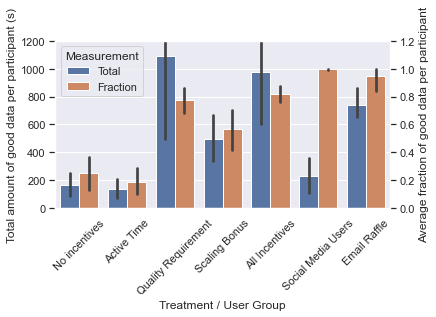

In [8]:
env_data_scaled = env_data.copy()

# Scale the data, just a simple example of how you might determine the scaling
mask = env_data_scaled.Measurement.isin(['Fraction',])
# scale = int(env_data_scaled[~mask].value.mean()
            # /env_data_scaled[mask].value.mean())
scale = 1000
env_data_scaled.loc[mask, 'value'] = env_data_scaled.loc[mask, 'value']*scale


fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
plt.ylim(0,1200)
fig.subplots_adjust(bottom=0.3)

# plot = sns.barplot(x="task", y="value", hue='Measurement', ci=95, data=env_data_scaled, order=incentive_tasks.values(), estimator=np.median)
plot = sns.barplot(x="task", y="value", hue='Measurement', ci=95, data=env_data_scaled, order=incentive_tasks.values())
# Create a second y-axis with the scaled ticks
ax1.set_ylabel('Total amount of good data per participant (s)')
ax1.set_xlabel('Treatment / User Group')
ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.grid(None)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax2.set_ylabel('Average fraction of good data per participant')



plt.savefig("incentives.pdf")
plt.show()
plt.close()

And we also generate a table of p-values for each combination of treatments:

In [62]:
import scipy

for measurement in ['Total', 'Fraction']:
    print(f"Measurement: {measurement}")
    print("\\hline")
    print(f"vs & ", end='')
    for it2 in reversed(range(len(incentive_tasks.values()))):
        if it2 == 0: continue
        t2 = list(incentive_tasks.values())[it2]
        print(f"{t2} {'&' if not it2 == 1 else ''} ", end='')
    print("\\\\")
    print("\\hline")
    for it1 in range(len(incentive_tasks.values())):
        if it1 == len(incentive_tasks.values()) - 1: continue
        t1 = list(incentive_tasks.values())[it1]
        print(f"{t1} & ", end='')
        for it2 in reversed(range(len(incentive_tasks.values()))):
            if it2 == 0: continue
            t2 = list(incentive_tasks.values())[it2]
            cat1 = env_data[env_data['task']==t1][env_data['Measurement']==measurement]
            cat2 = env_data[env_data['task']==t2][env_data['Measurement']==measurement]
            test = scipy.stats.ttest_ind(cat1['value'], cat2['value'])
            if it2 > it1:
                if test.pvalue <= 0.05:
                    print(f"\\textbf{{{test.pvalue:.3f}}} {'&' if not it2 == 1 else ''} ", end='')
                else:
                    print(f"{test.pvalue:.3f} {'&' if not it2 == 1 else ''} ", end='')
            else:
                print(f" {'&' if not it2 == 1 else ''}", end='')
        print("\\\\")
        print("\\hline")


Measurement: Total
\hline
vs & Email Raffle & Social Media Users & All Incentives & Scaling Bonus & Quality Requirement & Active Time  \\
\hline
No incentives & \textbf{0.000} & 0.600 & \textbf{0.000} & \textbf{0.001} & \textbf{0.006} & 0.621  \\
\hline
Active Time & \textbf{0.000} & 0.362 & \textbf{0.000} & \textbf{0.000} & \textbf{0.006} &  \\
\hline
Quality Requirement & 0.738 & 0.368 & 0.811 & 0.105 &  & \\
\hline
Scaling Bonus & 0.341 & 0.256 & \textbf{0.021} &  & & \\
\hline
All Incentives & 0.658 & 0.135 &  & & & \\
\hline
Social Media Users & \textbf{0.002} &  & & & & \\
\hline
Measurement: Fraction
\hline
vs & Email Raffle & Social Media Users & All Incentives & Scaling Bonus & Quality Requirement & Active Time  \\
\hline
No incentives & \textbf{0.001} & \textbf{0.000} & \textbf{0.000} & \textbf{0.001} & \textbf{0.000} & 0.440  \\
\hline
Active Time & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} &  \\
\hline
Quality Requirement & 0.152 & \

/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 & \\
\hline
Scaling Bonus & 0.086 & \textbf{0.031} & \textbf{0.006} &  & & \\
\hline
All Incentives & 0.123 & \textbf{0.016} &  & & & \\
\hline
Social Media Users & 0.318 &  & & & & \\
\hline


## Multiagent data: human-human vs human-AI

In many nominally human-human multiagent settings, we use fallback AI policies to take over if one human disconnects, to ensure an uninterrupted experience for the remaining human player. We would like to account correctly for how much human-human multiagent data we have. We did not store this as metadata explicitly when we collected these trajectories, but we do store inside the trajectory the agents in control at every frame. So we calculate the amount of human-human and human-AI data now. To do that, we load each trajectory, and count the number of frames where two humans were present as well as the number of frames where one humand and one AI were playing.

In [4]:
ai_tasks = ['space_invaders_2p_competitive_mturk', 'space_invaders_2p_cooperative_mturk', 'space_invaders_2p_competitive_email', 'space_invaders_2p_cooperative_email', 'spaceinvaders_cooperative_socialmedia']


In [5]:
processed = 0
unprocessed = 0
for ep in all_episodes:
    if ep.environment.task_id in ai_tasks:
        if 'total_frames_humanhuman' not in ep.keyword_data['all']:
            print(f"{ep.episode_id}")
            unprocessed += 1
        else:
            processed += 1
print(f"Processed: {processed}, unprocessed: {unprocessed}, total: {processed+unprocessed}")

Processed: 3021, unprocessed: 0, total: 3021


In [ ]:
# Calculate exact human-human and human-AI data in MTurk tasks
# You MUST run the first two cells of the notebook again after this, or things WILL break.
n = 0
for task in ai_tasks:
    num_frames_humanhuman = 0
    num_frames_humanai = 0
    for ep in all_episodes:
        if ep.environment.task_id == task:
            if 'all' not in ep.keyword_data or 'total_frames_humanhuman' not in ep.keyword_data['all']:
                print(f"Parsing episode {ep.episode_id}")
                trajectory = get_trajectory_by_id(ep.episode_id)
                num_frames_humanhuman = 0
                num_frames_humanai = 0
                for step in trajectory:
                    if step['user_type']['game_0>player_0'] == 1 and step['user_type']['game_0>player_1'] == 1:
                        num_frames_humanhuman += 1
                    elif step['user_type']['game_0>player_0'] == 2 or step['user_type']['game_0>player_1'] == 2:
                        num_frames_humanai += 1
                    else:
                        print(f"Unexpected user types: {step.user_types}")
                kw_model = EpisodeKeywordDataModel(
                            episode_id=ep.episode_id,
                            agent_id='all',
                            key='total_frames_humanhuman',
                            value=num_frames_humanhuman,
                        )
                session.merge(kw_model)
                session.commit()
                kw_model = EpisodeKeywordDataModel(
                            episode_id=ep.episode_id,
                            agent_id='all',
                            key='total_frames_humanai',
                            value=num_frames_humanai,
                        )
                session.merge(kw_model)
                session.commit()
                n+=1
                print(f"Processed {n} episodes.")
            else:
                print(f"Skipping episode {ep.episode_id}")
all_episodes = session.query(EpisodeModel).all()

In [52]:
for task in ai_tasks:
    num_frames_humanhuman = 0
    num_frames_humanai = 0
    for ep in all_episodes:
        if ep.environment.task_id == task:
            num_frames_humanhuman += ep.keyword_data['all']['total_frames_humanhuman']
            num_frames_humanai += ep.keyword_data['all']['total_frames_humanai']
    print(f"Task {task} has total frames human-human: {num_frames_humanhuman}, in hours: {num_frames_humanhuman/(60*60*60)},      total frames human-AI: {num_frames_humanai}, in hours: {num_frames_humanai/(60*60*60)}")
    # print(f"Task {task} has total frames human-AI: {num_frames_humanai}, in hours: {num_frames_humanai/(60*60*60)}")

Task space_invaders_2p_competitive_mturk has total frames human-human: 560868, in hours: 2.596611111111111,      total frames human-AI: 8348264, in hours: 38.64937037037037
Task space_invaders_2p_cooperative_mturk has total frames human-human: 810848, in hours: 3.753925925925926,      total frames human-AI: 1239179, in hours: 5.736939814814815
Task space_invaders_2p_competitive_email has total frames human-human: 90672, in hours: 0.4197777777777778,      total frames human-AI: 0, in hours: 0.0
Task space_invaders_2p_cooperative_email has total frames human-human: 84686, in hours: 0.3920648148148148,      total frames human-AI: 0, in hours: 0.0
Task spaceinvaders_cooperative_socialmedia has total frames human-human: 82613, in hours: 0.3824675925925926,      total frames human-AI: 0, in hours: 0.0


## Dataset overview tables

We now automatically generate the overview tables with the number of hours of data for each game and type of task. You must first run the code in the Multiagent data section

In [11]:
all_games = {env.keyword_data['all']['game'] for env in all_environments if 'all' in env.keyword_data and 'game' in env.keyword_data['all']}
all_tasks_kw = {env.keyword_data['all']['task'] for env in all_environments if 'all' in env.keyword_data and 'task' in env.keyword_data['all']}
all_sources = {env.keyword_data['all']['source'] for env in all_environments if 'all' in env.keyword_data and 'source' in env.keyword_data['all']}
print(sorted(all_games))
print(sorted(all_tasks_kw))
print(sorted(all_sources))

['beam_rider', 'breakout', 'montezuma_revenge', 'qbert', 'riverraid', 'space_invaders', 'space_invaders_2p', 'space_invaders_ai']
['competitive', 'cooperative', 'insideout', 'insideout_incentives', 'left', 'outsidein', 'plain', 'right', 'rowbyrow']
['email', 'mturk', 'socialmedia']


In [12]:
nice_task_names = {
    'beam_rider': 'Beamrider',
    'breakout': 'Breakout',
    'montezuma_revenge': 'Montezuma\'s Revenge', 
    'qbert': 'Q*Bert', 
    'riverraid': 'Riverraid', 
    'space_invaders': 'Space Invaders', 
    'space_invaders_2p': 'Space Invaders (2P)', 
    'space_invaders_ai': 'Space Invaders (2P w/AI)'
}

In [13]:
all_tasks_sorted = ['plain', 'competitive', 'cooperative', 'left', 'right', 'insideout', 'outsidein', 'rowbyrow', 'insideout_incentives', ]

In [14]:
def get_total_time_by_variant(game=None, task=None, source=None, output = 'str'):
    
    base_condition = lambda x: 'all' in x.keyword_data and 'game' in x.keyword_data['all'] and 'task' in x.keyword_data['all'] and 'source' in x.keyword_data['all']
    def condition(name, var):
        if isinstance(var, str):
            return lambda x: x.keyword_data['all'][name]==var
        elif isinstance(var,list) or isinstance(var,tuple):
            return lambda x: x.keyword_data['all'][name] in var
        else:
            return lambda x: True
    if game != 'space_invaders_2p' and game !='space_invaders_ai':
        s = sum([env.keyword_data[P1]['Time played']/timedelta(hours=1) for env in all_environments if base_condition(env) and condition('game', game)(env) and condition('task', task)(env) and condition('source', source)(env)])
    elif game == 'space_invaders_ai':
        s = sum([env.keyword_data[P1]['Time played']/timedelta(hours=1) for env in all_environments if base_condition(env) and condition('game', game)(env) and condition('task', task)(env) and condition('source', source)(env)])
        s += sum([sum([ep.keyword_data['all']['total_frames_humanai']/(60*60*60) for ep in env.episodes]) for env in all_environments if base_condition(env) and condition('game', 'space_invaders_2p')(env) and condition('task', task)(env) and condition('source', source)(env)])
    
    else: 
        s = sum([sum([ep.keyword_data['all']['total_frames_humanhuman']/(60*60*60) for ep in env.episodes]) for env in all_environments if base_condition(env) and condition('game', game)(env) and condition('task', task)(env) and condition('source', source)(env)])
    
    if output == 'float':
        return s
    if s > 0:
        return f"{s:.2f}"
    return '-'

for g in sorted(all_games):
    print(f"\\textbf{{{nice_task_names[g]}}} & \\textbf{{{get_total_time_by_variant(game=g, source='mturk')}}} & \\textbf{{{get_total_time_by_variant(game=g, source='socialmedia')}}} & \\textbf{{{get_total_time_by_variant(game=g, source='email')}}} & \\textbf{{{get_total_time_by_variant(game=g)}}} \\\\")
    n = 0
    for t in all_tasks_sorted:
        if get_total_time_by_variant(game=g, task=t, output='float') > 0:
            n += 1
    if n > 1:
        for t in all_tasks_sorted:
            if get_total_time_by_variant(game=g, task=t, output='float') > 0:
                print(f"    - {t.replace('_', ' ')} & {get_total_time_by_variant(game=g, task=t, source='mturk')} & {get_total_time_by_variant(game=g, task=t, source='socialmedia')} & {get_total_time_by_variant(game=g, task=t, source='email')} & {get_total_time_by_variant(game=g, task=t)} \\\\")
print("\\\\ \hline \\\\")
print(f"\\textbf{{Total}} & \\textbf{{{get_total_time_by_variant(source='mturk')}}} & \\textbf{{{get_total_time_by_variant(source='socialmedia')}}} & \\textbf{{{get_total_time_by_variant(source='email')}}} & \\textbf{{{get_total_time_by_variant()} }}\\\\")


\textbf{Beamrider} & \textbf{7.90} & \textbf{-} & \textbf{-} & \textbf{7.90} \\
\textbf{Breakout} & \textbf{11.45} & \textbf{-} & \textbf{-} & \textbf{11.45} \\
\textbf{Montezuma's Revenge} & \textbf{16.70} & \textbf{3.75} & \textbf{5.19} & \textbf{25.65} \\
\textbf{Q*Bert} & \textbf{6.97} & \textbf{2.90} & \textbf{-} & \textbf{9.87} \\
\textbf{Riverraid} & \textbf{17.64} & \textbf{4.47} & \textbf{3.10} & \textbf{25.20} \\
    - plain & 5.35 & 3.78 & 2.00 & 11.12 \\
    - left & 6.78 & 0.45 & 0.70 & 7.94 \\
    - right & 5.51 & 0.23 & 0.40 & 6.14 \\
\textbf{Space Invaders} & \textbf{196.09} & \textbf{18.34} & \textbf{7.10} & \textbf{221.53} \\
    - plain & 13.22 & 17.83 & 5.98 & 37.03 \\
    - left & 18.80 & - & - & 18.80 \\
    - right & 36.35 & - & - & 36.35 \\
    - insideout & 16.49 & 0.42 & 1.12 & 18.03 \\
    - outsidein & 13.44 & - & - & 13.44 \\
    - rowbyrow & 16.38 & 0.09 & - & 16.47 \\
    - insideout incentives & 81.41 & - & - & 81.41 \\


KeyError: 'total_frames_humanhuman'

In [23]:
task_groups = {
    'left': 'multimodal',
    'right': 'multimodal',
    'insideout': 'multimodal',
    'outsidein': 'multimodal',
    'rowbyrow': 'multimodal',
    'insideout_incentives': 'incentives',
}
for g in sorted(all_games):
    print(f"\\textbf{{{nice_task_names[g]}}} & \\textbf{{{get_total_time_by_variant(game=g, source='mturk')}}} & \\textbf{{{get_total_time_by_variant(game=g, source='socialmedia')}}} & \\textbf{{{get_total_time_by_variant(game=g, source='email')}}} & \\textbf{{{get_total_time_by_variant(game=g)}}} \\\\")
    n = 0
    for t in sorted(all_tasks_kw):
        if get_total_time_by_variant(game=g, task=t, output='float') > 0 and t in task_groups:
            n += 1
    if n > 1:
        for t in set(task_groups.values()):
            if sum([get_total_time_by_variant(game=g, task=q, output='float') for q in task_groups.keys() if task_groups[q]==t]) > 0 :
                print(f"    - of which {t.replace('_', ' ')} & {sum([get_total_time_by_variant(game=g, task=q, source='mturk', output='float') for q in task_groups.keys() if task_groups[q]==t]):.2f} & {sum([get_total_time_by_variant(game=g, task=q, source='socialmedia', output='float') for q in task_groups.keys() if task_groups[q]==t]):.2f} & {sum([get_total_time_by_variant(game=g, task=q, source='email', output='float') for q in task_groups.keys() if task_groups[q]==t]):.2f} & {sum([get_total_time_by_variant(game=g, task=q, output='float') for q in task_groups.keys() if task_groups[q]==t]):.2f} \\\\")
print("\\\\ \hline \\\\")
print(f"\\textbf{{Total}} & \\textbf{{{get_total_time_by_variant(source='mturk')}}} & \\textbf{{{get_total_time_by_variant(source='socialmedia')}}} & \\textbf{{{get_total_time_by_variant(source='email')}}} & \\textbf{{{get_total_time_by_variant()} }}\\\\")


\textbf{Beamrider} & \textbf{7.90} & \textbf{-} & \textbf{-} & \textbf{7.90} \\
\textbf{Breakout} & \textbf{11.45} & \textbf{-} & \textbf{-} & \textbf{11.45} \\
\textbf{Montezuma's Revenge} & \textbf{16.70} & \textbf{3.75} & \textbf{5.19} & \textbf{25.65} \\
\textbf{Q*Bert} & \textbf{6.97} & \textbf{2.90} & \textbf{-} & \textbf{9.87} \\
\textbf{Riverraid} & \textbf{17.64} & \textbf{4.47} & \textbf{3.10} & \textbf{25.20} \\
    - of which multimodal & 12.29 & 0.69 & 1.10 & 14.08 \\
\textbf{Space Invaders} & \textbf{297.69} & \textbf{18.34} & \textbf{7.10} & \textbf{323.13} \\
    - of which incentives & 183.01 & 0.00 & 0.00 & 183.01 \\
    - of which multimodal & 101.46 & 0.52 & 1.12 & 103.09 \\
\textbf{Space Invaders (2P)} & \textbf{6.35} & \textbf{0.38} & \textbf{0.81} & \textbf{7.54} \\
\textbf{Space Invaders (2P w/AI)} & \textbf{54.98} & \textbf{2.54} & \textbf{1.41} & \textbf{58.93} \\
\\ \hline \\
\textbf{Total} & \textbf{419.67} & \textbf{32.38} & \textbf{17.60} & \textbf{469.66 

In [6]:
total_users = len({user.permanent_user_id for user in all_users})
print(f"Total number of unique visitors {total_users}")

Total number of unique visitors 1249


## Data collected over time

Not part of the paper: This shows the amount of data collected each day, and also each weekday (no clear trend there).

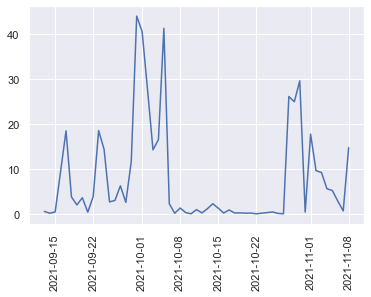

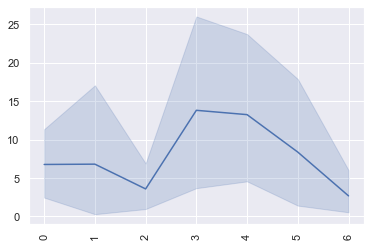

In [30]:
# Show data collected per day

dates = {}
for ep in all_episodes:
    if ep.keyword_data['all']['created_on'].date() not in dates:
        dates[ep.keyword_data['all']['created_on'].date()] = ep.keyword_data[P1]['Time played'].total_seconds() / 3600
    else:
        dates[ep.keyword_data['all']['created_on'].date()] += ep.keyword_data[P1]['Time played'].total_seconds() / 3600

plot = sns.lineplot(x=dates.keys(), y=dates.values(),  ci=95, )
# plot.set_yscale("log")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Show data collected per day of week

weekdays = []
data_per_weekday = []
for d in dates:
    weekdays.append(d.weekday())
    data_per_weekday.append(dates[d])

plot = sns.lineplot(x=weekdays, y=data_per_weekday,  ci=95, )
# plot.set_yscale("log")
plt.xticks(rotation=90)
plt.show()
plt.close()